# Machine learning algorithms for identifying antibiotic resistant bacteria

- We will be focussing on a species called Neisseria gonorrhoeae, the bacteria which cause gonorrhoea
- Many people who are infected (especially women) experience no symptoms, helping the disease to spread
- Resistance of these bacteria to antibiotics is rising over time, making infections hard to treat.
- Currently in the UK, patients are only treated with ceftriaxone.
- In this notebook, we will look at machine learning algorithms for predicting resistance to azithromycin.

In [1]:
# set up environment
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sns
import time

### Data
- We have genome sequence and antibiotic resistance data gathered from different publicly available sources (https://microreact.org/project/N_gonorrhoeae)

- We're using unitigs, short stretches of DNA shared by a subset of the strains in our study.
- Unitigs are an efficient but flexible way of representing DNA variation in bacteria (https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007758)


- The full dataset consists of 584,362 unitigs, which takes a long time to train models on, so for this exercise we will be using a set that has been filtered for unitigs statistically associated with resistance.

- We call the different resistance patterns 'phenotypes', which is a general term for traits that an organism has.

- Info that we need : 
    - Presence/absence pattern of the unitigs across each sample (X) 
    - How resistant each sample is to an antibiotic (pheno)


In [2]:
# a function for preparing our training and testing data
def prep_data(phenotype) :
    pheno = pd.read_csv('data/gono-unitigs/metadata.csv', index_col=0)
    pheno = pheno.dropna(subset=[phenotype]) # drop samples that don't have a value for our chosen resistance profile
    pheno = pheno[phenotype]
        
    # read in unitig data
    X = pd.read_csv('data/gono-unitigs/' + phenotype + '_gwas_filtered_unitigs.Rtab', sep=" ", index_col=0, low_memory=False)
    X = X.transpose()
    X = X[X.index.isin(pheno.index)] # only keep rows with a resistance measure
    pheno = pheno[pheno.index.isin(X.index)]
    return X, pheno

In [3]:
# let's predict azithromycin resistance 
# prepare our data for predicting antibiotic resistance
phenotype = 'azm_sr'
X, pheno = prep_data(phenotype)

# create an array for storing performance metrics
performance = []
method = []
times = []

In [4]:
# take a look at the data

print(pheno.shape)
print(pheno.head())
print('-'*100)
print(X.shape)
print(X.iloc[:10,:10])

(3478,)
Sample_ID
ERR1549286    1.0
ERR1549290    1.0
ERR1549291    1.0
ERR1549287    1.0
ERR1549288    1.0
Name: azm_sr, dtype: float64
----------------------------------------------------------------------------------------------------
(3478, 515)
pattern_id  CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG  \
ERR1549286                                                0   
ERR1549290                                                0   
ERR1549291                                                0   
ERR1549287                                                0   
ERR1549288                                                0   
ERR1549299                                                0   
ERR1549292                                                0   
ERR1549298                                                0   
ERR1549296                                                0   
ERR1549300                                                0   

pattern_id  TACCGTAACCGGCAATGCGGATATTACGGTC  CAGACGGCATT

Index(['CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG',
       'TACCGTAACCGGCAATGCGGATATTACGGTC', 'CAGACGGCATTTTTTTTGCGTTTTTCGGGAGG',
       'AACGGGTTTTCAGACGGCATTCGATATCGGGACG',
       'CCAAAAATTACCCGCGTTGACGTAGCTAAAGA',
       'CGGACCGGTATTCCGTCGAAATCACCGCCGTCAACCGCCCC',
       'TGAAATTGTCCATCTCGTATGCCGTCTTCTGCTTG',
       'TACGGTATTGTCCGCATTATTAAACTCAAAACC,AGAAGACGGCATACGAGATGGACAATTTCATCC',
       'GGCATTTTTTTTGCGTTTTTCGGGAGGGGGCGGC',
       'TATATAAGGGGTTGCCGTTCCGCAGTTGGGCGGCAGCATAC'],
      dtype='object', name='pattern_id')


/tmp/ipykernel_1202835/3522010014.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(uni_len)


<Axes: ylabel='Density'>

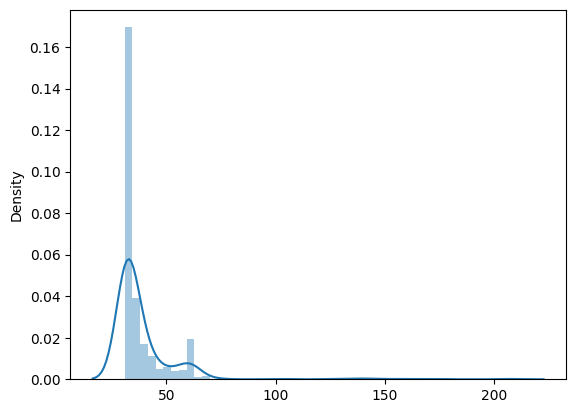

In [5]:
# look at the length distribution of the unitigs in our dataset
unitigs = X.columns
print(unitigs[:10])
mylen = np.vectorize(len)
uni_len = mylen(unitigs)
sns.distplot(uni_len)

### Modeling

- Here we will use cross validaion to see how well the model will work on new data
- Here is the steps : 
    - split data into 5 folds / and buit 5 models
    - model tuning with GridSearchCV
    - evaluate model based on Accuracy (cv)
    

In [6]:
# function for fitting a model
def fitmodel(X, pheno, estimator, parameters, modelname, method, performance, times) :
    
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        # time how long it takes to train each model type
        start = time.process_time()
        
        # split data into train/test sets
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        # perform grid search to identify best hyper-parameters
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
        # predict resistance in test set
        y_pred = gs_clf.predict(X_test)
                
        # call all samples with a predicted value less than or equal to 0.5 as sensitive to the antibiotic, 
        # and samples with predicted value >0.5 resistant to the antibiotic
        y_pred[y_pred<=0.5] = 0
        y_pred[y_pred>0.5] = 1

        score = balanced_accuracy_score(y_test, y_pred)
        performance = np.append(performance, score)
        method = np.append(method, modelname)
        times = np.append(times, (time.process_time() - start))

        print("Best hyperparameters for this fold")
        print(gs_clf.best_params_)
        print("Confusion matrix for this fold")
        print(confusion_matrix(y_test, y_pred))
    return gs_clf, method, performance, times

In [7]:
def sbplot(X, pheno, estimator, parameters, modelname, method, performance, times) :
    results = []
    
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        # time how long it takes to train each model type
        start = time.process_time()
        
        # split data into train/test sets
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        # perform grid search to identify best hyper-parameters
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
        # predict resistance in test set
        y_pred = gs_clf.predict(X_test)
        
        results.append([y_test, y_pred])
        
    return results

In [8]:
enet = SGDClassifier(loss="log_loss", penalty="elasticnet")
enet_params = {
    'l1_ratio': [0.1, 0.2, 0.5]
}

enet_model, method, performance, times = fitmodel(X, pheno, enet, enet_params, "Elastic net", method, performance, times)

/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[533  17]
 [ 36 110]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[686   2]
 [  0   8]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[644   5]
 [  6  41]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[603  22]
 [ 26  44]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[507  12]
 [ 33 143]]


In [9]:
svm = SVC(class_weight='balanced')
svm_params = {
    'C': [0.01],
    'gamma': [1e-06, 1e-05],
    'kernel': ['linear']
}

svm_model, method, performance, times = fitmodel(X, pheno, svm, svm_params, "Support vector machine", method, performance, times)

/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[687   1]
 [  0   8]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[638  11]
 [  2  45]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[590  35]
 [  5  65]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


In [10]:
xgb_mod = xgb.XGBClassifier(random_state=0)
xgb_params = {
    'alpha': [1e-5, 1e-4], 
    'colsample_bytree': [0.6],
    'gamma': [0.05, 0.1], 
    'learning_rate': [0.01, 0.1], 
    'max_depth': [2], 
    'objective': ['binary:hinge'], 
    'subsample': [0.2, 0.4, 0.6]
}

xgb_model, method, performance, times = fitmodel(X, pheno, xgb_mod, xgb_params, "XGBoost", method, performance, times)

/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[538  12]
 [ 17 129]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.6}
Confusion matrix for this fold
[[687   1]
 [  0   8]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.4}
Confusion matrix for this fold
[[638  11]
 [  2  45]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.4}
Confusion matrix for this fold
[[590  35]
 [ 10  60]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[505  14]
 [  7 169]]


In [11]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
rf_params = {
    'max_features': [round(X.shape[1]*0.1), round(X.shape[1]*0.5), round(X.shape[1]*0.8)],
    'max_depth': [3],
    'n_estimators': [50]
}

rf_model, method, performance, times = fitmodel(X, pheno, rf, rf_params, "Random forest", method, performance, times)

/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 412, 'n_estimators': 50}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[681   7]
 [  0   8]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[637  12]
 [  2  45]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[588  37]
 [  5  65]]


/tmp/ipykernel_1202835/2801341832.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train = pheno[train_index]
/tmp/ipykernel_1202835/2801341832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = pheno[test_index]


Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


/tmp/ipykernel_1202835/1236822003.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x=method, y=performance, palette="YlGnBu_d", size=10, edgecolor='black')


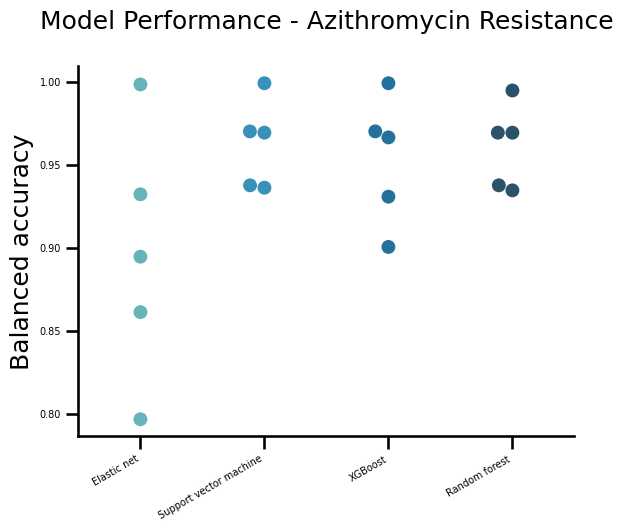

In [45]:
# compare results from the different predictors
sns.set_context("talk")
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sns.swarmplot(x=method, y=performance, palette="YlGnBu_d", size=10, edgecolor='black')
sns.despine()
plt.ylabel("Balanced accuracy")
plt.xticks(rotation=30, ha='right', fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('issues/svm_acc.png')

/tmp/ipykernel_1202835/2688400953.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x=method, y=times, palette="YlGnBu_d", size=10)


([0, 1, 2, 3],
 [Text(0, 0, 'Elastic net'),
  Text(1, 0, 'Support vector machine'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'Random forest')])

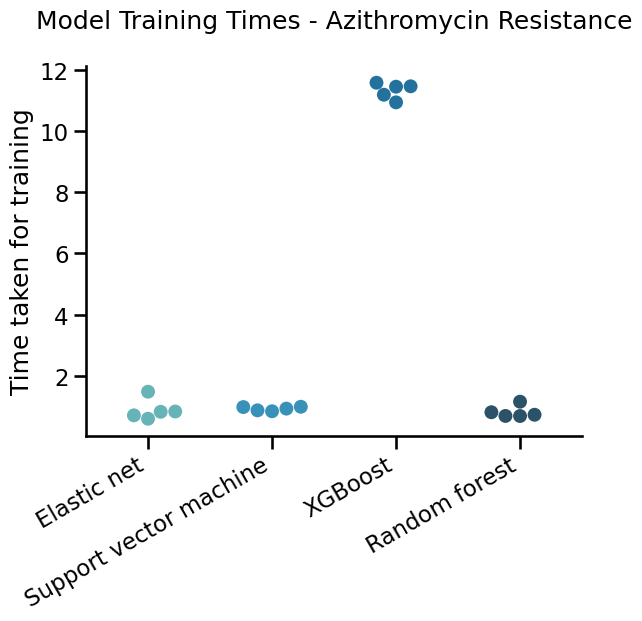

In [13]:
# took at the time taken to train the different models
sns.set_context("talk")
plt.title("Model Training Times - Azithromycin Resistance", y=1.08)
sns.swarmplot(x=method, y=times, palette="YlGnBu_d", size=10)
sns.despine()
plt.ylabel("Time taken for training")
plt.xticks(rotation=30, ha='right')

### Exploring what the model has learned

In [39]:
# function for looking at SVM feature importance
def plot_coefficients(classifier, feature_names, top_features=5, export=True):
    coef = classifier.best_estimator_.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    sns.set_context("poster")
    plt.figure(figsize=(10, 5))
    plt.title("Feature Importances (Support Vector Machine) - Azithromycin Resistance", fontsize=15)
    colors = ['crimson' if c < 0 else 'cornflowerblue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors, edgecolor='black', width=0.6)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    if export:
        plt.savefig('issues/FI_svm_azm_resistance.png',dpi=300)
    plt.show()
    np.asarray(feature_names)[top_positive_coefficients]


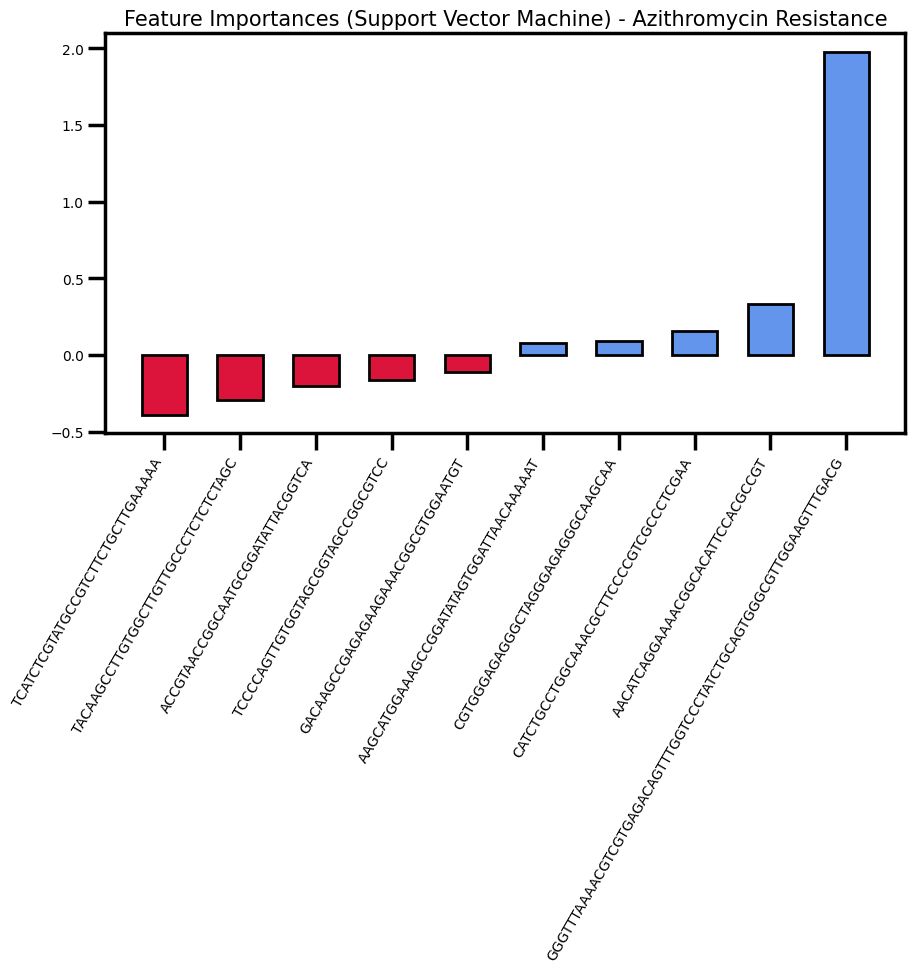

Top negative predictors:  ['TCATCTCGTATGCCGTCTTCTGCTTGAAAAA' 'TACAAGCCTTGTGGCTTGTTGCCCTCTCTCTAGC'
 'ACCGTAACCGGCAATGCGGATATTACGGTCA' 'TCCCCAGTTGTGGTAGCGGTAGCCGGCGTCC'
 'GACAAGCCGAGAGAAGAAACGGCGTGGAATGT']
Top positive predictors:  ['AAGCATGGAAAGCCGGATATAGTGGATTAACAAAAAT' 'CGTGGGAGAGGGCTAGGGAGAGGGCAAGCAA'
 'CATCTGCCTGGCAAACGCTTCCCCGTCGCCCTCGAA' 'AACATCAGGAAAACGGCACATTCCACGCCGT'
 'GGGTTTAAAACGTCGTGAGACAGTTTGGTCCCTATCTGCAGTGGGCGTTGGAAGTTTGACG']


In [40]:
plot_coefficients(svm_model, list(X.columns))
    
# if we print the unitigs, we can then look at what genes they relate to
coef = svm_model.best_estimator_.coef_.ravel()
feature_names = list(X.columns)
top_negative_coefficients = np.argsort(coef)[:5]
print("Top negative predictors: ", np.asarray(feature_names)[top_negative_coefficients])

top_positive_coefficients = np.argsort(coef)[-5:]
print("Top positive predictors: ", np.asarray(feature_names)[top_positive_coefficients])